# preprocess of recurrence

In [1]:
# 基本的なライブラリ
import sys
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# パイプライン
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from pipelines import *

# データ分割
from sklearn.model_selection import train_test_split

# スケーリング
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# 次元削減
from sklearn.decomposition import PCA

import config
import functions

SEED = config.SEED
functions.fix_seed(SEED)
TARGET_NAME = ["RFS_STATUS", "RFS_MONTHS"]
STRATIFY_NAME = "RFS_STATUS"
%matplotlib inline

/home/breast-cancer-analytics/notebooks/functions.py:196: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y_train: pd.Series(),
/home/breast-cancer-analytics/notebooks/functions.py:198: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y_val: pd.Series(),


# データ読み込み

In [2]:
df_patient = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR + "/data_clinical_patient.txt", header=4
)
df_sample = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR + "/data_clinical_sample.txt", header=4
)
df_clinical = pd.merge(df_patient, df_sample, on="PATIENT_ID")

## カラムの順序変更（読みやすさのため）

In [3]:
def align_columns(df: pd.DataFrame, regex: str):
    # まとめたいcolumnの正規表現を一時退避
    _df = df.copy()
    df_tmp = _df.filter(regex=regex)
    # 元のdfから落とす
    _df.drop(df_tmp.columns, axis=1, inplace=True)
    # 元のdfに結合
    return pd.merge(_df, df_tmp, right_index=True, left_index=True)


def sort_columns_by_knowledge(df):
    _df = df.copy()
    # 癌の種類
    _df = align_columns(_df, "^CANCER_")
    # 重要そう（直感）な特徴量
    _df = align_columns(_df, "^ER_|^HER2_|^TUMOR_")
    # 治療の種類
    _df = align_columns(_df, ".*THERAPY$|^BREAST_SURGERY")
    # target系の種類（OS, RFS, VITAL）
    _df = align_columns(_df, "^OS_.*|^RFS_.*|^VITAL_.*")
    return _df


df_clinical = sort_columns_by_knowledge(df_clinical)

In [4]:
# データを大きく2つに分割できるので、ここで分割
df_MB = df_clinical[df_clinical["PATIENT_ID"].str.contains("MB")]
df_MTST = df_clinical[df_clinical["PATIENT_ID"].str.contains("MTS-T")]

df_MB.set_index("PATIENT_ID", inplace=True)
df_MTST.set_index("PATIENT_ID", inplace=True)

display(df_MB.shape, df_MTST.shape)
# save
functions.make_dir(config.INTERIM_PREPROCESSED_RECURRENCE_DIR)
df_clinical.to_pickle(config.INTERIM_PREPROCESSED_RECURRENCE_DIR + "/df_clinical.pkl")
df_MB.to_pickle(config.INTERIM_PREPROCESSED_RECURRENCE_DIR + "/df_MB.pkl")
df_MTST.to_pickle(config.INTERIM_PREPROCESSED_RECURRENCE_DIR + "/df_MTST.pkl")
del df_patient, df_sample, df_clinical, df_MB, df_MTST

(1985, 35)

(524, 35)

## 臨床・遺伝子データの読み込み

In [5]:
# 臨床データ
df_MB = pd.read_pickle(config.INTERIM_PREPROCESSED_RECURRENCE_DIR + "/df_MB.pkl")

# 遺伝子発現データ
# 生の遺伝子発現データ
df_mrna_agilent_microarray = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR + "/data_mrna_agilent_microarray.txt", index_col=0
).T
df_mrna_agilent_microarray = df_mrna_agilent_microarray.drop(
    "Entrez_Gene_Id"
).sort_index()

# 前処理
- 目的変数生成
- 特徴量生成
- 特徴名のrename 
- 欠損値の削除


## 目的変数の生成

目的変数は再発年数（連続値）である。しかし、RFS_STATUSが0の患者は非再発であり、RFS_MONTHSは手術〜最終フォローアップの期間を示している。
そこで、非再発患者のRFS_MONTHSは0にする必要がある。

## 特徴量生成
予測の**層別化に必要な特徴を生成**する。

**層別化に必要な特徴**
- CLAUDIN_SUBTYPE
- NPI
- TUMOR_SIZE
- LYMPH_NODES_EXAMINED_POSITIVE

数値データは層別化のためにカテゴリ化を行う。
各カテゴリ化の根拠は以下の通り。
- NPI：( ノッティンガムの予後指数：https://en.wikipedia.org/wiki/Nottingham_Prognostic_Index )
- TUMOR_SIZE：乳癌のステージの定義( https://oshiete-gan.jp/breast/diagnosis/stages/detail.html )
- LYMPH_NODES_EXAMINED_POSITIVE：https://medical.nikkeibp.co.jp/leaf/all/cancernavi/news/201403/535575.html

## 特徴量名のrename
重複した特徴量は別のものとして扱う


## 欠損値の削除
- 欠損値が多い→特徴量の削除  
- 欠損値が少ない→サンプルの削除

In [6]:
def generate_target():
    # RFS_STATUS, RFS_MONTHSのnullデータについては患者データを削除する
    df_MB.dropna(subset=["RFS_STATUS", "RFS_MONTHS"], inplace=True)
    # 予測ラベルを扱いやすい形に変更
    # scikit-survivalの予測モデルでは、RFS_STATUSがboolである必要がある（イベント発生がTrue, 打ち切りがFalse）
    df_MB["RFS_STATUS"] = df_MB["RFS_STATUS"].replace(
        {"1:Recurred": True, "0:Not Recurred": False}
    )


def generate_features():
    df_MB["NPI_CAT"] = pd.cut(
        df_MB.NPI,
        [0, 2.0, 2.4, 3.4, 5.4, np.inf],
        labels=["0.0~2.0", "2.0~2.4", "2.4~3.4", "3.4~5.4", "5.4~inf"],
    )
    df_MB["TUMOR_CAT"] = pd.cut(
        df_MB.TUMOR_SIZE, [0, 20, 50, np.inf], labels=["0~20", "20~50", "50~inf"]
    )
    df_MB["LYMPH_CAT"] = pd.cut(
        df_MB.LYMPH_NODES_EXAMINED_POSITIVE,
        [-np.inf, 0, 3, np.inf],
        labels=["0", "1~3", "4~inf"],
    )


def rename_duplicatged_columns(df):
    _df = df.copy()
    # 重複特徴量の確認
    print(
        "重複特徴名数（rename前）：",
        _df.columns[_df.columns.duplicated()].value_counts().sum(),
    )

    cols = pd.Series(_df.columns)
    for dup in cols[cols.duplicated()].unique():
        cols[cols[cols == dup].index.values.tolist()] = [
            dup + "_" + str(i) if i != 0 else dup for i in range(sum(cols == dup))
        ]

    # rename the columns with the cols list.
    _df.columns = cols
    # 重複特徴量の確認
    print(
        "重複特徴名数（rename後）：",
        _df.columns[_df.columns.duplicated()].value_counts().sum(),
    )
    return _df


def drop_null4cols(df):
    _df = df.copy()
    print(
        "欠損値が多い特徴個数：",
        (_df.isnull().sum() > _df.shape[0] // 10).sum(),
    )
    features = _df.isnull().sum().sort_values()[::-1]
    features.plot()

    # 多数の欠損値を持つ特徴
    many_null_features = features[_df.isnull().sum() > _df.shape[0] // 10].index
    # 多数の欠損値を持つ特徴の削除
    _df.drop(many_null_features, axis=1, inplace=True)
    return _df


def drop_null4raws(df):
    _df = df.copy()
    print(
        "欠損値が少ない特徴個数：",
        ((_df.isnull().sum() < +_df.shape[0] // 10) & (_df.isnull().sum() > 0)).sum(),
    )
    features = _df.isnull().sum().sort_values()[::-1]
    features.plot()

    # 少数の欠損値を持つ特徴
    few_null_features = features[
        (_df.isnull().sum() <= _df.shape[0] // 10) & (_df.isnull().sum() > 0)
    ]
    # 少数の欠損値の遺伝子発現を持つ患者ID
    list_patient_id_contains_null_expressions = list()
    for name in few_null_features.index:
        for patient_id in _df[_df[name].isnull()].index:
            list_patient_id_contains_null_expressions.append(patient_id)

    # 少数の欠損値の遺伝子発現を持つ患者の削除
    _df.drop(list_patient_id_contains_null_expressions, inplace=True)
    return _df

重複特徴名数（rename前）： 194
重複特徴名数（rename後）： 0
欠損値が多い特徴個数： 0
欠損値が少ない特徴個数： 8


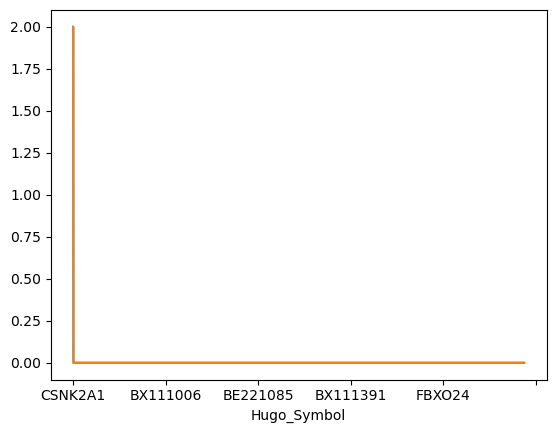

In [7]:
# 臨床データ
generate_target()
generate_features()
# 遺伝子データ
df_gene_expressions = df_mrna_agilent_microarray.copy()
df_gene_expressions = rename_duplicatged_columns(df_gene_expressions)
df_gene_expressions = drop_null4cols(df_gene_expressions)
df_gene_expressions = drop_null4raws(df_gene_expressions)
# save
functions.make_dir(config.INTERIM_PREPROCESSED_RECURRENCE_DIR)
df_gene_expressions.to_pickle(
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR + "/df_gene_expressions.pkl"
)

# 臨床データと遺伝子データの結合

患者の必要な特徴を含む臨床データと遺伝子データを結合する。

## 臨床データ

**必要な特徴**

目的変数
- RFS_OVER_nMONTHS  

層別化対象候補
- CLAUDIN_SUBTYPE
- NPI_CAT
- TUMOR_CAT
- LYMPH_CAT

## 遺伝子データ
遺伝子データは全ての特徴量を結合する。

In [26]:
left_features = [
    "RFS_MONTHS",
    "RFS_STATUS",
    "CLAUDIN_SUBTYPE",
    "THREEGENE",
]

df_merged = pd.merge(
    df_MB[left_features],
    df_gene_expressions,
    left_index=True,
    right_index=True,
)
# 半角スペースやバックスラッシュはpklファイル保存時に邪魔になるので置き換え
df_merged["THREEGENE"] = df_merged.THREEGENE.str.replace("/", "_")
df_merged["THREEGENE"] = df_merged.THREEGENE.str.replace(" ", "_")

# save
functions.make_dir(config.INTERIM_PREPROCESSED_RECURRENCE_DIR)
df_merged.to_pickle(
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR + "/df_merged4numeric.pkl"
)
df_recurrenced = df_merged.copy()
# save
functions.make_dir(config.INTERIM_PREPROCESSED_RECURRENCE_DIR)
df_merged.to_pickle(
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR + "/df_recurrenced4numeric.pkl"
)

## データ分割

訓練データ、検証データ、テストデータに層化分割する   
比率は(train, val, test)=(0.81, 0.09, 0.1)  
CVは行わずに通常のholdoutで検証は行う（特徴選択を毎度実施するのが厄介なため）


In [27]:
# データ分割のためのクラス
# pythonのミュータブルオブジェクトの外部操作を防ぐためにcopy()の使用&private化
class SplitDataFrame:
    def __init__(self, df, train_size: float = 0.9):
        self.__df = df.copy()
        self.__train_size = train_size

        self.__df_train = None
        self.__df_val = None
        self.__df_train_val = None
        self.__df_test = None

        self.__X_train = None
        self.__y_train = None
        self.__X_val = None
        self.__y_val = None
        self.__X_train_val = None
        self.__y_train_val = None
        self.__X_test = None
        self.__y_test = None

    def split_train_val_test(self):
        # train & test
        self.__df_train_val, self.__df_test = train_test_split(
            self.__df,
            train_size=self.__train_size,
            stratify=self.__df[STRATIFY_NAME],
            random_state=SEED,
        )
        # train & val
        self.__df_train, self.__df_val = train_test_split(
            self.__df_train_val,
            train_size=self.__train_size,
            stratify=self.__df_train_val[STRATIFY_NAME],
            random_state=SEED,
        )

    def split_X_y(self):
        self.__X_train, self.__y_train = (
            self.__df_train.drop(TARGET_NAME, axis=1),
            self.__df_train[TARGET_NAME],
        )
        self.__X_val, self.__y_val = (
            self.__df_val.drop(TARGET_NAME, axis=1),
            self.__df_val[TARGET_NAME],
        )
        self.__X_train_val, self.__y_train_val = (
            self.__df_train_val.drop(TARGET_NAME, axis=1),
            self.__df_train_val[TARGET_NAME],
        )
        self.__X_test, self.__y_test = (
            self.__df_test.drop(TARGET_NAME, axis=1),
            self.__df_test[TARGET_NAME],
        )

    def get_train_val(self):
        return self.__train_val.copy()

    def get_train(self):
        return self.__train.copy()

    def get_val(self):
        return self.__val.copy()

    def get_test(self):
        return self.__test.copy()

    def get_train_val_Xy(self):
        return self.__X_train_val.copy(), self.__y_train_val.copy()

    def get_train_Xy(self):
        return self.__X_train.copy(), self.__y_train.copy()

    def get_val_Xy(self):
        return self.__X_val.copy(), self.__y_val.copy()

    def get_test_Xy(self):
        return self.__X_test.copy(), self.__y_test.copy()

# 前処理パイプライン

In [28]:
def save_preprocessed_df(
    list_train: list(),
    list_test: list(),
    val_step: str,
    save_file_path: str = ".",
):
    """
    params
    list_train: [X_train, y_train]
    list_test: [X_test, y_test]
    """
    # 検証用データセットの保存
    train_path = "{0}/{1}/train".format(save_file_path, val_step)
    test_path = "{0}/{1}/test".format(save_file_path, val_step)

    functions.make_dir(train_path)
    functions.pickle_dump(list_train[0], "{0}/X.pkl".format(train_path))
    functions.pickle_dump(list_train[1], "{0}/y.pkl".format(train_path))
    functions.make_dir(test_path)
    functions.pickle_dump(list_test[0], "{0}/X.pkl".format(test_path))
    functions.pickle_dump(list_test[1], "{0}/y.pkl".format(test_path))


def save_preprocess_pipeline(
    pipeline: callable,
    val_step: str,
    save_file_path: str = ".",
):
    # 検証用データセットの保存
    train_path = "{0}/{1}/train".format(save_file_path, val_step)
    test_path = "{0}/{1}/test".format(save_file_path, val_step)

    functions.make_dir(train_path)
    functions.pickle_dump(pipeline, "{0}/preprocess_pipeline.pkl".format(train_path))
    functions.make_dir(test_path)
    functions.pickle_dump(pipeline, "{0}/preprocess_pipeline.pkl".format(test_path))

In [29]:
def skip_preprocess(df: pd.DataFrame()) -> bool:
    """
    入力データフレームを前処理するか判断

    True: 前処理をする
    False: 前処理をしない
    """
    return True if df.shape[0] > 100 else False


def apply_preprocess(
    df: pd.DataFrame(),
    preprocess_order: dict = {"original_data": []},
    save_file_path: str = None,
):
    _df = df.copy()

    # データが少なすぎる場合は特徴選択しない
    if not skip_preprocess(_df):
        return

    # データ分割
    _sp = SplitDataFrame(_df)
    _sp.split_train_val_test()
    _sp.split_X_y()

    _X_train, _y_train = _sp.get_train_Xy()
    _X_val, _y_val = _sp.get_val_Xy()
    _X_train_val, _y_train_val = _sp.get_train_val_Xy()
    _X_test, _y_test = _sp.get_test_Xy()

    # train&val と train_val&test のそれぞれのセットに適用
    dict_datasets = {
        "val_set": [[_X_train, _y_train], [_X_val, _y_val]],
        "test_set": [[_X_train_val, _y_train_val], [_X_test, _y_test]],
    }
    # 検証用、テスト用それぞれのセットへのパイプラインの適用
    for key, values in dict_datasets.items():
        # set_config(display="diagram")
        _preprocess_pipeline = Pipeline(steps=preprocess_order)
        _preprocess_pipeline.fit(values[0][0], values[0][1])
        values[0][0] = _preprocess_pipeline.transform(values[0][0])
        values[1][0] = _preprocess_pipeline.transform(values[1][0])

        print(
            "X_train: ",
            values[0][0].shape,
            " X_test: ",
            values[1][0].shape,
        )

        # 保存
        if save_file_path:
            save_preprocessed_df(
                list_train=[values[0][0], values[0][1]],
                list_test=[values[1][0], values[1][1]],
                val_step=key,
                save_file_path=save_file_path,
            )
            save_preprocess_pipeline(
                _preprocess_pipeline,
                val_step=key,
                save_file_path=save_file_path,
            )

In [32]:
def loop_preprocess():
    # 層別化する特徴量
    subgroup_columns = [
        "CLAUDIN_SUBTYPE",
        "THREEGENE",
    ]
    # 遺伝子発現量以外の特徴量を削除
    drop_columns = [
        "CLAUDIN_SUBTYPE",
        "THREEGENE",
    ]

    # 実施したい前処理パイプラインの定義
    preprocess_order_dicts = [
        {
            "preprocess_name": "preprocess4numeric_pca{0}".format(PCA_PERCENTILE),
            "preprocess_order": [
                (
                    StandardScalerAsDataFrame().__class__.__name__,
                    StandardScalerAsDataFrame(),
                ),
                (
                    PCA().__class__.__name__,
                    PCA(n_components=PCA_PERCENTILE / 100, random_state=config.SEED),
                ),
            ],
        },
    ]

    for subgroup_column in subgroup_columns:  # 各サブグループへの適用
        for subgroup in df_recurrenced[subgroup_column].unique():  # サブグループの要素毎への適用
            df = df_recurrenced[df_recurrenced[subgroup_column] == subgroup].drop(
                drop_columns, axis=1
            )
            print(subgroup, ": ", df.shape)
            for preprocess_order_dict in preprocess_order_dicts:
                output_data_path = "./{0}/{1}/{2}/{3}".format(
                    config.INTERIM_PREPROCESSED_RECURRENCE_DIR,
                    subgroup_column,
                    subgroup,
                    preprocess_order_dict["preprocess_name"],
                )
                apply_preprocess(
                    df,
                    preprocess_order=preprocess_order_dict["preprocess_order"],
                    save_file_path=output_data_path,
                )

In [33]:
for p in range(25, 80):
    print("++++++++++" * 10)
    print(p)
    PCA_PERCENTILE = p
    loop_preprocess()

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
25
claudin-low :  (197, 24370)
X_train:  (159, 7)  X_test:  (18, 7)
X_train:  (177, 7)  X_test:  (20, 7)
LumA :  (673, 24370)
X_train:  (544, 12)  X_test:  (61, 12)
X_train:  (605, 12)  X_test:  (68, 12)
LumB :  (460, 24370)
X_train:  (372, 12)  X_test:  (42, 12)
X_train:  (414, 12)  X_test:  (46, 12)
Her2 :  (218, 24370)
X_train:  (176, 7)  X_test:  (20, 7)
X_train:  (196, 8)  X_test:  (22, 8)
Normal :  (140, 24370)
X_train:  (113, 7)  X_test:  (13, 7)
X_train:  (126, 7)  X_test:  (14, 7)
Basal :  (199, 24370)
X_train:  (161, 9)  X_test:  (18, 9)
X_train:  (179, 9)  X_test:  (20, 9)
NC :  (6, 24370)
ER-_HER2- :  (290, 24370)
X_train:  (234, 9)  X_test:  (27, 9)
X_train:  (261, 9)  X_test:  (29, 9)
ER+_HER2-_High_Prolif :  (600, 24370)
X_train:  (486, 14)  X_test:  (54, 14)
X_train:  (540, 15)  X_test:  (60, 15)
nan :  (0, 24370)
ER+_HER2-_Low_Prolif :  (615, 24370)
X_train:  (497, 11) 

In [34]:
def apply_preprocess2late_recurrences(
    df: pd.DataFrame(),
    preprocess_pipeline_path: str,
    save_file_path: str = None,
):
    _df = df.copy()
    _X = _df.drop(TARGET_NAME, axis=1)
    _y = _df[TARGET_NAME]

    # 検証用、テスト用それぞれのセットへのパイプラインの適用
    _preprocess_pipeline = functions.pickle_load(
        preprocess_pipeline_path + "/preprocess_pipeline.pkl"
    )
    display(_X.shape)
    _X = _preprocess_pipeline.transform(_X)
    display(_X.shape)

    # 保存
    if save_file_path:
        functions.make_dir(save_file_path)
        functions.pickle_dump(_X, save_file_path + "/X.pkl")
        functions.pickle_dump(_y, save_file_path + "/y.pkl")

In [35]:
def loop_late_recurrences_data():
    # 層別化する特徴量
    subgroup_columns = [
        "CLAUDIN_SUBTYPE",
        "THREEGENE",
    ]
    # 遺伝子発現量以外の特徴量を削除
    drop_columns = [
        "CLAUDIN_SUBTYPE",
        "THREEGENE",
    ]

    preprocess_order_dicts = [
        {
            "preprocess_name": "preprocess4numeric_pca{0}".format(PCA_PERCENTILE),
        }
    ]
    val_step = "test_set"

    for subgroup_column in subgroup_columns:  # 各サブグループへの適用
        for subgroup in df_recurrenced[subgroup_column].unique():  # サブグループの要素毎への適用
            df = df_recurrenced[df_recurrenced[subgroup_column] == subgroup].drop(
                drop_columns, axis=1
            )
            df = df[(df.RFS_STATUS == True) & (df.RFS_MONTHS > 60)]
            if df.shape[0] < 5:
                continue

            print(subgroup, ": ", df.shape)
            for preprocess_order_dict in preprocess_order_dicts:
                subgroup_path = "./{0}/{1}/{2}/{3}".format(
                    subgroup_column,
                    subgroup,
                    preprocess_order_dict["preprocess_name"],
                    val_step,
                )
                input_pipe_path = "./{0}/{1}/{2}".format(
                    config.INTERIM_PREPROCESSED_RECURRENCE_DIR, subgroup_path, "train"
                )
                output_data_path = "./{0}/{1}/{2}".format(
                    config.INTERIM_PREPROCESSED_RECURRENCE_DIR,
                    subgroup_path,
                    "late_recurrences",
                )
                apply_preprocess2late_recurrences(df, input_pipe_path, output_data_path)

In [36]:
# 実施したい前処理パイプラインの定義
for p in range(25, 80):
    print("++++++++++" * 10)
    print(p)
    PCA_PERCENTILE = p
    loop_late_recurrences_data()

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
25
claudin-low :  (22, 24370)


(22, 24368)

(22, 7)

LumA :  (119, 24370)


(119, 24368)

(119, 12)

LumB :  (87, 24370)


(87, 24368)

(87, 12)

Her2 :  (29, 24370)


(29, 24368)

(29, 8)

Normal :  (27, 24370)


(27, 24368)

(27, 7)

Basal :  (8, 24370)


(8, 24368)

(8, 9)

ER-_HER2- :  (20, 24370)


(20, 24368)

(20, 9)

ER+_HER2-_High_Prolif :  (105, 24370)


(105, 24368)

(105, 15)

ER+_HER2-_Low_Prolif :  (114, 24370)


(114, 24368)

(114, 11)

HER2+ :  (16, 24370)


(16, 24368)

(16, 10)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
26
claudin-low :  (22, 24370)


(22, 24368)

(22, 7)

LumA :  (119, 24370)


(119, 24368)

(119, 13)

LumB :  (87, 24370)


(87, 24368)

(87, 14)

Her2 :  (29, 24370)


(29, 24368)

(29, 8)

Normal :  (27, 24370)


(27, 24368)

(27, 7)

Basal :  (8, 24370)


(8, 24368)

(8, 10)

ER-_HER2- :  (20, 24370)


(20, 24368)

(20, 10)

ER+_HER2-_High_Prolif :  (105, 24370)


(105, 24368)

(105, 16)

ER+_HER2-_Low_Prolif :  (114, 24370)


(114, 24368)

(114, 12)

HER2+ :  (16, 24370)


(16, 24368)

(16, 10)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
27
claudin-low :  (22, 24370)


(22, 24368)

(22, 8)

LumA :  (119, 24370)


(119, 24368)

(119, 14)

LumB :  (87, 24370)


(87, 24368)

(87, 15)

Her2 :  (29, 24370)


(29, 24368)

(29, 9)

Normal :  (27, 24370)


(27, 24368)

(27, 8)

Basal :  (8, 24370)


(8, 24368)

(8, 11)

ER-_HER2- :  (20, 24370)


(20, 24368)

(20, 11)

ER+_HER2-_High_Prolif :  (105, 24370)


(105, 24368)

(105, 18)

ER+_HER2-_Low_Prolif :  (114, 24370)


(114, 24368)

(114, 13)

HER2+ :  (16, 24370)


(16, 24368)

(16, 11)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
28
claudin-low :  (22, 24370)


(22, 24368)

(22, 8)

LumA :  (119, 24370)


(119, 24368)

(119, 16)

LumB :  (87, 24370)


(87, 24368)

(87, 16)

Her2 :  (29, 24370)


(29, 24368)

(29, 10)

Normal :  (27, 24370)


(27, 24368)

(27, 9)

Basal :  (8, 24370)


(8, 24368)

(8, 12)

ER-_HER2- :  (20, 24370)


(20, 24368)

(20, 12)

ER+_HER2-_High_Prolif :  (105, 24370)


(105, 24368)

(105, 19)

ER+_HER2-_Low_Prolif :  (114, 24370)


(114, 24368)

(114, 14)

HER2+ :  (16, 24370)


(16, 24368)

(16, 12)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
29
claudin-low :  (22, 24370)


(22, 24368)

(22, 9)

LumA :  (119, 24370)


(119, 24368)

(119, 17)

LumB :  (87, 24370)


(87, 24368)

(87, 18)

Her2 :  (29, 24370)


(29, 24368)

(29, 11)

Normal :  (27, 24370)


(27, 24368)

(27, 9)

Basal :  (8, 24370)


(8, 24368)

(8, 13)

ER-_HER2- :  (20, 24370)


(20, 24368)

(20, 13)

ER+_HER2-_High_Prolif :  (105, 24370)


(105, 24368)

(105, 21)

ER+_HER2-_Low_Prolif :  (114, 24370)


(114, 24368)

(114, 16)

HER2+ :  (16, 24370)


(16, 24368)

(16, 13)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
30
claudin-low :  (22, 24370)


(22, 24368)

(22, 10)

LumA :  (119, 24370)


(119, 24368)

(119, 19)

LumB :  (87, 24370)


(87, 24368)

(87, 19)

Her2 :  (29, 24370)


(29, 24368)

(29, 11)

Normal :  (27, 24370)


(27, 24368)

(27, 10)

Basal :  (8, 24370)


(8, 24368)

(8, 14)

ER-_HER2- :  (20, 24370)


(20, 24368)

(20, 14)

ER+_HER2-_High_Prolif :  (105, 24370)


(105, 24368)

(105, 23)

ER+_HER2-_Low_Prolif :  (114, 24370)


(114, 24368)

(114, 17)

HER2+ :  (16, 24370)


(16, 24368)

(16, 14)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
31
claudin-low :  (22, 24370)


(22, 24368)

(22, 10)

LumA :  (119, 24370)


(119, 24368)

(119, 21)

LumB :  (87, 24370)


(87, 24368)

(87, 21)

Her2 :  (29, 24370)


(29, 24368)

(29, 12)

Normal :  (27, 24370)


(27, 24368)

(27, 10)

Basal :  (8, 24370)


(8, 24368)

(8, 15)

ER-_HER2- :  (20, 24370)


(20, 24368)

(20, 16)

ER+_HER2-_High_Prolif :  (105, 24370)


(105, 24368)

(105, 25)

ER+_HER2-_Low_Prolif :  (114, 24370)


(114, 24368)

(114, 19)

HER2+ :  (16, 24370)


(16, 24368)

(16, 15)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
32
claudin-low :  (22, 24370)


(22, 24368)

(22, 11)

LumA :  (119, 24370)


(119, 24368)

(119, 23)

LumB :  (87, 24370)


(87, 24368)

(87, 23)

Her2 :  (29, 24370)


(29, 24368)

(29, 14)

Normal :  (27, 24370)


(27, 24368)

(27, 11)

Basal :  (8, 24370)


(8, 24368)

(8, 16)

ER-_HER2- :  (20, 24370)


(20, 24368)

(20, 17)

ER+_HER2-_High_Prolif :  (105, 24370)


(105, 24368)

(105, 27)

ER+_HER2-_Low_Prolif :  (114, 24370)


(114, 24368)

(114, 21)

HER2+ :  (16, 24370)


(16, 24368)

(16, 16)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
33
claudin-low :  (22, 24370)


(22, 24368)

(22, 12)

LumA :  (119, 24370)


(119, 24368)

(119, 25)

LumB :  (87, 24370)


(87, 24368)

(87, 25)

Her2 :  (29, 24370)


(29, 24368)

(29, 15)

Normal :  (27, 24370)


(27, 24368)

(27, 12)

Basal :  (8, 24370)


(8, 24368)

(8, 17)

ER-_HER2- :  (20, 24370)


(20, 24368)

(20, 18)

ER+_HER2-_High_Prolif :  (105, 24370)


(105, 24368)

(105, 30)

ER+_HER2-_Low_Prolif :  (114, 24370)


(114, 24368)

(114, 23)

HER2+ :  (16, 24370)


(16, 24368)

(16, 17)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
34
claudin-low :  (22, 24370)


(22, 24368)

(22, 13)

LumA :  (119, 24370)


(119, 24368)

(119, 27)

LumB :  (87, 24370)


(87, 24368)

(87, 27)

Her2 :  (29, 24370)


(29, 24368)

(29, 16)

Normal :  (27, 24370)


(27, 24368)

(27, 12)

Basal :  (8, 24370)


(8, 24368)

(8, 18)

ER-_HER2- :  (20, 24370)


(20, 24368)

(20, 20)

ER+_HER2-_High_Prolif :  (105, 24370)


(105, 24368)

(105, 32)

ER+_HER2-_Low_Prolif :  (114, 24370)


(114, 24368)

(114, 25)

HER2+ :  (16, 24370)


(16, 24368)

(16, 18)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
35
claudin-low :  (22, 24370)


(22, 24368)

(22, 14)

LumA :  (119, 24370)


(119, 24368)

(119, 30)

LumB :  (87, 24370)


(87, 24368)

(87, 29)

Her2 :  (29, 24370)


(29, 24368)

(29, 17)

Normal :  (27, 24370)


(27, 24368)

(27, 13)

Basal :  (8, 24370)


(8, 24368)

(8, 19)

ER-_HER2- :  (20, 24370)


(20, 24368)

(20, 21)

ER+_HER2-_High_Prolif :  (105, 24370)


(105, 24368)

(105, 35)

ER+_HER2-_Low_Prolif :  (114, 24370)


(114, 24368)

(114, 27)

HER2+ :  (16, 24370)


(16, 24368)

(16, 19)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
36
claudin-low :  (22, 24370)


(22, 24368)

(22, 14)

LumA :  (119, 24370)


(119, 24368)

(119, 32)

LumB :  (87, 24370)


(87, 24368)

(87, 31)

Her2 :  (29, 24370)


(29, 24368)

(29, 18)

Normal :  (27, 24370)


(27, 24368)

(27, 14)

Basal :  (8, 24370)


(8, 24368)

(8, 20)

ER-_HER2- :  (20, 24370)


(20, 24368)

(20, 23)

ER+_HER2-_High_Prolif :  (105, 24370)


(105, 24368)

(105, 38)

ER+_HER2-_Low_Prolif :  (114, 24370)


(114, 24368)

(114, 30)

HER2+ :  (16, 24370)


(16, 24368)

(16, 21)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
37
claudin-low :  (22, 24370)


(22, 24368)

(22, 15)

LumA :  (119, 24370)


(119, 24368)

(119, 35)

LumB :  (87, 24370)


(87, 24368)

(87, 34)

Her2 :  (29, 24370)


(29, 24368)

(29, 20)

Normal :  (27, 24370)


(27, 24368)

(27, 15)

Basal :  (8, 24370)


(8, 24368)

(8, 22)

ER-_HER2- :  (20, 24370)


(20, 24368)

(20, 24)

ER+_HER2-_High_Prolif :  (105, 24370)


(105, 24368)

(105, 41)

ER+_HER2-_Low_Prolif :  (114, 24370)


(114, 24368)

(114, 32)

HER2+ :  (16, 24370)


(16, 24368)

(16, 22)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
38
claudin-low :  (22, 24370)


(22, 24368)

(22, 16)

LumA :  (119, 24370)


(119, 24368)

(119, 38)

LumB :  (87, 24370)


(87, 24368)

(87, 36)

Her2 :  (29, 24370)


(29, 24368)

(29, 21)

Normal :  (27, 24370)


(27, 24368)

(27, 16)

Basal :  (8, 24370)


(8, 24368)

(8, 23)

ER-_HER2- :  (20, 24370)


(20, 24368)

(20, 26)

ER+_HER2-_High_Prolif :  (105, 24370)


(105, 24368)

(105, 44)

ER+_HER2-_Low_Prolif :  (114, 24370)


(114, 24368)

(114, 35)

HER2+ :  (16, 24370)


(16, 24368)

(16, 23)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
39
claudin-low :  (22, 24370)


(22, 24368)

(22, 18)

LumA :  (119, 24370)


(119, 24368)

(119, 41)

LumB :  (87, 24370)


(87, 24368)

(87, 39)

Her2 :  (29, 24370)


(29, 24368)

(29, 23)

Normal :  (27, 24370)


(27, 24368)

(27, 17)

Basal :  (8, 24370)


(8, 24368)

(8, 24)

ER-_HER2- :  (20, 24370)


(20, 24368)

(20, 28)

ER+_HER2-_High_Prolif :  (105, 24370)


(105, 24368)

(105, 47)

ER+_HER2-_Low_Prolif :  (114, 24370)


(114, 24368)

(114, 38)

HER2+ :  (16, 24370)


(16, 24368)

(16, 24)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
40
claudin-low :  (22, 24370)


(22, 24368)

(22, 19)

LumA :  (119, 24370)


(119, 24368)

(119, 45)

LumB :  (87, 24370)


(87, 24368)

(87, 42)

Her2 :  (29, 24370)


(29, 24368)

(29, 24)

Normal :  (27, 24370)


(27, 24368)

(27, 18)

Basal :  (8, 24370)


(8, 24368)

(8, 26)

ER-_HER2- :  (20, 24370)


(20, 24368)

(20, 29)

ER+_HER2-_High_Prolif :  (105, 24370)


(105, 24368)

(105, 50)

ER+_HER2-_Low_Prolif :  (114, 24370)


(114, 24368)

(114, 41)

HER2+ :  (16, 24370)


(16, 24368)

(16, 26)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
41
claudin-low :  (22, 24370)


(22, 24368)

(22, 20)

LumA :  (119, 24370)


(119, 24368)

(119, 48)

LumB :  (87, 24370)


(87, 24368)

(87, 45)

Her2 :  (29, 24370)


(29, 24368)

(29, 25)

Normal :  (27, 24370)


(27, 24368)

(27, 19)

Basal :  (8, 24370)


(8, 24368)

(8, 27)

ER-_HER2- :  (20, 24370)


(20, 24368)

(20, 31)

ER+_HER2-_High_Prolif :  (105, 24370)


(105, 24368)

(105, 54)

ER+_HER2-_Low_Prolif :  (114, 24370)


(114, 24368)

(114, 45)

HER2+ :  (16, 24370)


(16, 24368)

(16, 27)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
42
claudin-low :  (22, 24370)


(22, 24368)

(22, 21)

LumA :  (119, 24370)


(119, 24368)

(119, 52)

LumB :  (87, 24370)


(87, 24368)

(87, 48)

Her2 :  (29, 24370)


(29, 24368)

(29, 27)

Normal :  (27, 24370)


(27, 24368)

(27, 20)

Basal :  (8, 24370)


(8, 24368)

(8, 29)

ER-_HER2- :  (20, 24370)


(20, 24368)

(20, 33)

ER+_HER2-_High_Prolif :  (105, 24370)


(105, 24368)

(105, 58)

ER+_HER2-_Low_Prolif :  (114, 24370)


(114, 24368)

(114, 48)

HER2+ :  (16, 24370)


(16, 24368)

(16, 29)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
43
claudin-low :  (22, 24370)


(22, 24368)

(22, 23)

LumA :  (119, 24370)


(119, 24368)

(119, 56)

LumB :  (87, 24370)


(87, 24368)

(87, 51)

Her2 :  (29, 24370)


(29, 24368)

(29, 29)

Normal :  (27, 24370)


(27, 24368)

(27, 21)

Basal :  (8, 24370)


(8, 24368)

(8, 30)

ER-_HER2- :  (20, 24370)


(20, 24368)

(20, 35)

ER+_HER2-_High_Prolif :  (105, 24370)


(105, 24368)

(105, 62)

ER+_HER2-_Low_Prolif :  (114, 24370)


(114, 24368)

(114, 52)

HER2+ :  (16, 24370)


(16, 24368)

(16, 30)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
44
claudin-low :  (22, 24370)


(22, 24368)

(22, 24)

LumA :  (119, 24370)


(119, 24368)

(119, 61)

LumB :  (87, 24370)


(87, 24368)

(87, 54)

Her2 :  (29, 24370)


(29, 24368)

(29, 30)

Normal :  (27, 24370)


(27, 24368)

(27, 22)

Basal :  (8, 24370)


(8, 24368)

(8, 32)

ER-_HER2- :  (20, 24370)


(20, 24368)

(20, 37)

ER+_HER2-_High_Prolif :  (105, 24370)


(105, 24368)

(105, 66)

ER+_HER2-_Low_Prolif :  (114, 24370)


(114, 24368)

(114, 56)

HER2+ :  (16, 24370)


(16, 24368)

(16, 32)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
45
claudin-low :  (22, 24370)


(22, 24368)

(22, 25)

LumA :  (119, 24370)


(119, 24368)

(119, 65)

LumB :  (87, 24370)


(87, 24368)

(87, 57)

Her2 :  (29, 24370)


(29, 24368)

(29, 32)

Normal :  (27, 24370)


(27, 24368)

(27, 23)

Basal :  (8, 24370)


(8, 24368)

(8, 33)

ER-_HER2- :  (20, 24370)


(20, 24368)

(20, 40)

ER+_HER2-_High_Prolif :  (105, 24370)


(105, 24368)

(105, 70)

ER+_HER2-_Low_Prolif :  (114, 24370)


(114, 24368)

(114, 60)

HER2+ :  (16, 24370)


(16, 24368)

(16, 33)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
46
claudin-low :  (22, 24370)


(22, 24368)

(22, 27)

LumA :  (119, 24370)


(119, 24368)

(119, 70)

LumB :  (87, 24370)


(87, 24368)

(87, 61)

Her2 :  (29, 24370)


(29, 24368)

(29, 34)

Normal :  (27, 24370)


(27, 24368)

(27, 24)

Basal :  (8, 24370)


(8, 24368)

(8, 35)

ER-_HER2- :  (20, 24370)


(20, 24368)

(20, 42)

ER+_HER2-_High_Prolif :  (105, 24370)


(105, 24368)

(105, 74)

ER+_HER2-_Low_Prolif :  (114, 24370)


(114, 24368)

(114, 65)

HER2+ :  (16, 24370)


(16, 24368)

(16, 35)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
47
claudin-low :  (22, 24370)


(22, 24368)

(22, 28)

LumA :  (119, 24370)


(119, 24368)

(119, 75)

LumB :  (87, 24370)


(87, 24368)

(87, 64)

Her2 :  (29, 24370)


(29, 24368)

(29, 36)

Normal :  (27, 24370)


(27, 24368)

(27, 25)

Basal :  (8, 24370)


(8, 24368)

(8, 37)

ER-_HER2- :  (20, 24370)


(20, 24368)

(20, 44)

ER+_HER2-_High_Prolif :  (105, 24370)


(105, 24368)

(105, 79)

ER+_HER2-_Low_Prolif :  (114, 24370)


(114, 24368)

(114, 69)

HER2+ :  (16, 24370)


(16, 24368)

(16, 36)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
48
claudin-low :  (22, 24370)


(22, 24368)

(22, 30)

LumA :  (119, 24370)


(119, 24368)

(119, 80)

LumB :  (87, 24370)


(87, 24368)

(87, 68)

Her2 :  (29, 24370)


(29, 24368)

(29, 37)

Normal :  (27, 24370)


(27, 24368)

(27, 26)

Basal :  (8, 24370)


(8, 24368)

(8, 38)

ER-_HER2- :  (20, 24370)


(20, 24368)

(20, 47)

ER+_HER2-_High_Prolif :  (105, 24370)


(105, 24368)

(105, 84)

ER+_HER2-_Low_Prolif :  (114, 24370)


(114, 24368)

(114, 74)

HER2+ :  (16, 24370)


(16, 24368)

(16, 38)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
49
claudin-low :  (22, 24370)


(22, 24368)

(22, 32)

LumA :  (119, 24370)


(119, 24368)

(119, 86)

LumB :  (87, 24370)


(87, 24368)

(87, 72)

Her2 :  (29, 24370)


(29, 24368)

(29, 39)

Normal :  (27, 24370)


(27, 24368)

(27, 28)

Basal :  (8, 24370)


(8, 24368)

(8, 40)

ER-_HER2- :  (20, 24370)


(20, 24368)

(20, 49)

ER+_HER2-_High_Prolif :  (105, 24370)


(105, 24368)

(105, 89)

ER+_HER2-_Low_Prolif :  (114, 24370)


(114, 24368)

(114, 79)

HER2+ :  (16, 24370)


(16, 24368)

(16, 40)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
50
claudin-low :  (22, 24370)


(22, 24368)

(22, 33)

LumA :  (119, 24370)


(119, 24368)

(119, 91)

LumB :  (87, 24370)


(87, 24368)

(87, 76)

Her2 :  (29, 24370)


(29, 24368)

(29, 41)

Normal :  (27, 24370)


(27, 24368)

(27, 29)

Basal :  (8, 24370)


(8, 24368)

(8, 42)

ER-_HER2- :  (20, 24370)


(20, 24368)

(20, 52)

ER+_HER2-_High_Prolif :  (105, 24370)


(105, 24368)

(105, 94)

ER+_HER2-_Low_Prolif :  (114, 24370)


(114, 24368)

(114, 84)

HER2+ :  (16, 24370)


(16, 24368)

(16, 41)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
51
claudin-low :  (22, 24370)


(22, 24368)

(22, 35)

LumA :  (119, 24370)


(119, 24368)

(119, 97)

LumB :  (87, 24370)


(87, 24368)

(87, 80)

Her2 :  (29, 24370)


(29, 24368)

(29, 43)

Normal :  (27, 24370)


(27, 24368)

(27, 30)

Basal :  (8, 24370)


(8, 24368)

(8, 43)

ER-_HER2- :  (20, 24370)


(20, 24368)

(20, 54)

ER+_HER2-_High_Prolif :  (105, 24370)


(105, 24368)

(105, 99)

ER+_HER2-_Low_Prolif :  (114, 24370)


(114, 24368)

(114, 90)

HER2+ :  (16, 24370)


(16, 24368)

(16, 43)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
52
claudin-low :  (22, 24370)


(22, 24368)

(22, 37)

LumA :  (119, 24370)


(119, 24368)

(119, 103)

LumB :  (87, 24370)


(87, 24368)

(87, 84)

Her2 :  (29, 24370)


(29, 24368)

(29, 45)

Normal :  (27, 24370)


(27, 24368)

(27, 31)

Basal :  (8, 24370)


(8, 24368)

(8, 45)

ER-_HER2- :  (20, 24370)


(20, 24368)

(20, 57)

ER+_HER2-_High_Prolif :  (105, 24370)


(105, 24368)

(105, 105)

ER+_HER2-_Low_Prolif :  (114, 24370)


(114, 24368)

(114, 96)

HER2+ :  (16, 24370)


(16, 24368)

(16, 45)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
53
claudin-low :  (22, 24370)


(22, 24368)

(22, 39)

LumA :  (119, 24370)


(119, 24368)

(119, 110)

LumB :  (87, 24370)


(87, 24368)

(87, 88)

Her2 :  (29, 24370)


(29, 24368)

(29, 47)

Normal :  (27, 24370)


(27, 24368)

(27, 33)

Basal :  (8, 24370)


(8, 24368)

(8, 47)

ER-_HER2- :  (20, 24370)


(20, 24368)

(20, 60)

ER+_HER2-_High_Prolif :  (105, 24370)


(105, 24368)

(105, 110)

ER+_HER2-_Low_Prolif :  (114, 24370)


(114, 24368)

(114, 101)

HER2+ :  (16, 24370)


(16, 24368)

(16, 47)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
54
claudin-low :  (22, 24370)


(22, 24368)

(22, 41)

LumA :  (119, 24370)


(119, 24368)

(119, 116)

LumB :  (87, 24370)


(87, 24368)

(87, 93)

Her2 :  (29, 24370)


(29, 24368)

(29, 49)

Normal :  (27, 24370)


(27, 24368)

(27, 34)

Basal :  (8, 24370)


(8, 24368)

(8, 49)

ER-_HER2- :  (20, 24370)


(20, 24368)

(20, 62)

ER+_HER2-_High_Prolif :  (105, 24370)


(105, 24368)

(105, 116)

ER+_HER2-_Low_Prolif :  (114, 24370)


(114, 24368)

(114, 107)

HER2+ :  (16, 24370)


(16, 24368)

(16, 48)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
55
claudin-low :  (22, 24370)


(22, 24368)

(22, 43)

LumA :  (119, 24370)


(119, 24368)

(119, 123)

LumB :  (87, 24370)


(87, 24368)

(87, 97)

Her2 :  (29, 24370)


(29, 24368)

(29, 52)

Normal :  (27, 24370)


(27, 24368)

(27, 35)

Basal :  (8, 24370)


(8, 24368)

(8, 51)

ER-_HER2- :  (20, 24370)


(20, 24368)

(20, 65)

ER+_HER2-_High_Prolif :  (105, 24370)


(105, 24368)

(105, 122)

ER+_HER2-_Low_Prolif :  (114, 24370)


(114, 24368)

(114, 114)

HER2+ :  (16, 24370)


(16, 24368)

(16, 50)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
56
claudin-low :  (22, 24370)


(22, 24368)

(22, 44)

LumA :  (119, 24370)


(119, 24368)

(119, 130)

LumB :  (87, 24370)


(87, 24368)

(87, 102)

Her2 :  (29, 24370)


(29, 24368)

(29, 54)

Normal :  (27, 24370)


(27, 24368)

(27, 37)

Basal :  (8, 24370)


(8, 24368)

(8, 53)

ER-_HER2- :  (20, 24370)


(20, 24368)

(20, 68)

ER+_HER2-_High_Prolif :  (105, 24370)


(105, 24368)

(105, 128)

ER+_HER2-_Low_Prolif :  (114, 24370)


(114, 24368)

(114, 120)

HER2+ :  (16, 24370)


(16, 24368)

(16, 52)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
57
claudin-low :  (22, 24370)


(22, 24368)

(22, 46)

LumA :  (119, 24370)


(119, 24368)

(119, 137)

LumB :  (87, 24370)


(87, 24368)

(87, 107)

Her2 :  (29, 24370)


(29, 24368)

(29, 56)

Normal :  (27, 24370)


(27, 24368)

(27, 38)

Basal :  (8, 24370)


(8, 24368)

(8, 55)

ER-_HER2- :  (20, 24370)


(20, 24368)

(20, 71)

ER+_HER2-_High_Prolif :  (105, 24370)


(105, 24368)

(105, 134)

ER+_HER2-_Low_Prolif :  (114, 24370)


(114, 24368)

(114, 126)

HER2+ :  (16, 24370)


(16, 24368)

(16, 54)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
58
claudin-low :  (22, 24370)


(22, 24368)

(22, 49)

LumA :  (119, 24370)


(119, 24368)

(119, 144)

LumB :  (87, 24370)


(87, 24368)

(87, 112)

Her2 :  (29, 24370)


(29, 24368)

(29, 58)

Normal :  (27, 24370)


(27, 24368)

(27, 39)

Basal :  (8, 24370)


(8, 24368)

(8, 57)

ER-_HER2- :  (20, 24370)


(20, 24368)

(20, 74)

ER+_HER2-_High_Prolif :  (105, 24370)


(105, 24368)

(105, 141)

ER+_HER2-_Low_Prolif :  (114, 24370)


(114, 24368)

(114, 133)

HER2+ :  (16, 24370)


(16, 24368)

(16, 56)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
59
claudin-low :  (22, 24370)


(22, 24368)

(22, 51)

LumA :  (119, 24370)


(119, 24368)

(119, 151)

LumB :  (87, 24370)


(87, 24368)

(87, 117)

Her2 :  (29, 24370)


(29, 24368)

(29, 61)

Normal :  (27, 24370)


(27, 24368)

(27, 41)

Basal :  (8, 24370)


(8, 24368)

(8, 59)

ER-_HER2- :  (20, 24370)


(20, 24368)

(20, 77)

ER+_HER2-_High_Prolif :  (105, 24370)


(105, 24368)

(105, 147)

ER+_HER2-_Low_Prolif :  (114, 24370)


(114, 24368)

(114, 140)

HER2+ :  (16, 24370)


(16, 24368)

(16, 58)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
60
claudin-low :  (22, 24370)


(22, 24368)

(22, 53)

LumA :  (119, 24370)


(119, 24368)

(119, 159)

LumB :  (87, 24370)


(87, 24368)

(87, 122)

Her2 :  (29, 24370)


(29, 24368)

(29, 63)

Normal :  (27, 24370)


(27, 24368)

(27, 42)

Basal :  (8, 24370)


(8, 24368)

(8, 61)

ER-_HER2- :  (20, 24370)


(20, 24368)

(20, 80)

ER+_HER2-_High_Prolif :  (105, 24370)


(105, 24368)

(105, 154)

ER+_HER2-_Low_Prolif :  (114, 24370)


(114, 24368)

(114, 147)

HER2+ :  (16, 24370)


(16, 24368)

(16, 60)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
61
claudin-low :  (22, 24370)


(22, 24368)

(22, 55)

LumA :  (119, 24370)


(119, 24368)

(119, 167)

LumB :  (87, 24370)


(87, 24368)

(87, 127)

Her2 :  (29, 24370)


(29, 24368)

(29, 65)

Normal :  (27, 24370)


(27, 24368)

(27, 44)

Basal :  (8, 24370)


(8, 24368)

(8, 63)

ER-_HER2- :  (20, 24370)


(20, 24368)

(20, 84)

ER+_HER2-_High_Prolif :  (105, 24370)


(105, 24368)

(105, 161)

ER+_HER2-_Low_Prolif :  (114, 24370)


(114, 24368)

(114, 154)

HER2+ :  (16, 24370)


(16, 24368)

(16, 62)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
62
claudin-low :  (22, 24370)


(22, 24368)

(22, 57)

LumA :  (119, 24370)


(119, 24368)

(119, 174)

LumB :  (87, 24370)


(87, 24368)

(87, 132)

Her2 :  (29, 24370)


(29, 24368)

(29, 68)

Normal :  (27, 24370)


(27, 24368)

(27, 45)

Basal :  (8, 24370)


(8, 24368)

(8, 66)

ER-_HER2- :  (20, 24370)


(20, 24368)

(20, 87)

ER+_HER2-_High_Prolif :  (105, 24370)


(105, 24368)

(105, 168)

ER+_HER2-_Low_Prolif :  (114, 24370)


(114, 24368)

(114, 161)

HER2+ :  (16, 24370)


(16, 24368)

(16, 64)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
63
claudin-low :  (22, 24370)


(22, 24368)

(22, 60)

LumA :  (119, 24370)


(119, 24368)

(119, 182)

LumB :  (87, 24370)


(87, 24368)

(87, 138)

Her2 :  (29, 24370)


(29, 24368)

(29, 70)

Normal :  (27, 24370)


(27, 24368)

(27, 47)

Basal :  (8, 24370)


(8, 24368)

(8, 68)

ER-_HER2- :  (20, 24370)


(20, 24368)

(20, 90)

ER+_HER2-_High_Prolif :  (105, 24370)


(105, 24368)

(105, 175)

ER+_HER2-_Low_Prolif :  (114, 24370)


(114, 24368)

(114, 168)

HER2+ :  (16, 24370)


(16, 24368)

(16, 66)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
64
claudin-low :  (22, 24370)


(22, 24368)

(22, 62)

LumA :  (119, 24370)


(119, 24368)

(119, 191)

LumB :  (87, 24370)


(87, 24368)

(87, 143)

Her2 :  (29, 24370)


(29, 24368)

(29, 73)

Normal :  (27, 24370)


(27, 24368)

(27, 49)

Basal :  (8, 24370)


(8, 24368)

(8, 70)

ER-_HER2- :  (20, 24370)


(20, 24368)

(20, 94)

ER+_HER2-_High_Prolif :  (105, 24370)


(105, 24368)

(105, 182)

ER+_HER2-_Low_Prolif :  (114, 24370)


(114, 24368)

(114, 176)

HER2+ :  (16, 24370)


(16, 24368)

(16, 68)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
65
claudin-low :  (22, 24370)


(22, 24368)

(22, 64)

LumA :  (119, 24370)


(119, 24368)

(119, 199)

LumB :  (87, 24370)


(87, 24368)

(87, 149)

Her2 :  (29, 24370)


(29, 24368)

(29, 75)

Normal :  (27, 24370)


(27, 24368)

(27, 50)

Basal :  (8, 24370)


(8, 24368)

(8, 72)

ER-_HER2- :  (20, 24370)


(20, 24368)

(20, 97)

ER+_HER2-_High_Prolif :  (105, 24370)


(105, 24368)

(105, 189)

ER+_HER2-_Low_Prolif :  (114, 24370)


(114, 24368)

(114, 183)

HER2+ :  (16, 24370)


(16, 24368)

(16, 71)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
66
claudin-low :  (22, 24370)


(22, 24368)

(22, 67)

LumA :  (119, 24370)


(119, 24368)

(119, 207)

LumB :  (87, 24370)


(87, 24368)

(87, 154)

Her2 :  (29, 24370)


(29, 24368)

(29, 78)

Normal :  (27, 24370)


(27, 24368)

(27, 52)

Basal :  (8, 24370)


(8, 24368)

(8, 75)

ER-_HER2- :  (20, 24370)


(20, 24368)

(20, 101)

ER+_HER2-_High_Prolif :  (105, 24370)


(105, 24368)

(105, 197)

ER+_HER2-_Low_Prolif :  (114, 24370)


(114, 24368)

(114, 191)

HER2+ :  (16, 24370)


(16, 24368)

(16, 73)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
67
claudin-low :  (22, 24370)


(22, 24368)

(22, 69)

LumA :  (119, 24370)


(119, 24368)

(119, 216)

LumB :  (87, 24370)


(87, 24368)

(87, 160)

Her2 :  (29, 24370)


(29, 24368)

(29, 81)

Normal :  (27, 24370)


(27, 24368)

(27, 54)

Basal :  (8, 24370)


(8, 24368)

(8, 77)

ER-_HER2- :  (20, 24370)


(20, 24368)

(20, 104)

ER+_HER2-_High_Prolif :  (105, 24370)


(105, 24368)

(105, 204)

ER+_HER2-_Low_Prolif :  (114, 24370)


(114, 24368)

(114, 199)

HER2+ :  (16, 24370)


(16, 24368)

(16, 75)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
68
claudin-low :  (22, 24370)


(22, 24368)

(22, 72)

LumA :  (119, 24370)


(119, 24368)

(119, 225)

LumB :  (87, 24370)


(87, 24368)

(87, 166)

Her2 :  (29, 24370)


(29, 24368)

(29, 83)

Normal :  (27, 24370)


(27, 24368)

(27, 55)

Basal :  (8, 24370)


(8, 24368)

(8, 79)

ER-_HER2- :  (20, 24370)


(20, 24368)

(20, 108)

ER+_HER2-_High_Prolif :  (105, 24370)


(105, 24368)

(105, 212)

ER+_HER2-_Low_Prolif :  (114, 24370)


(114, 24368)

(114, 207)

HER2+ :  (16, 24370)


(16, 24368)

(16, 77)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
69
claudin-low :  (22, 24370)


(22, 24368)

(22, 74)

LumA :  (119, 24370)


(119, 24368)

(119, 234)

LumB :  (87, 24370)


(87, 24368)

(87, 172)

Her2 :  (29, 24370)


(29, 24368)

(29, 86)

Normal :  (27, 24370)


(27, 24368)

(27, 57)

Basal :  (8, 24370)


(8, 24368)

(8, 82)

ER-_HER2- :  (20, 24370)


(20, 24368)

(20, 112)

ER+_HER2-_High_Prolif :  (105, 24370)


(105, 24368)

(105, 220)

ER+_HER2-_Low_Prolif :  (114, 24370)


(114, 24368)

(114, 215)

HER2+ :  (16, 24370)


(16, 24368)

(16, 80)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
70
claudin-low :  (22, 24370)


(22, 24368)

(22, 77)

LumA :  (119, 24370)


(119, 24368)

(119, 243)

LumB :  (87, 24370)


(87, 24368)

(87, 178)

Her2 :  (29, 24370)


(29, 24368)

(29, 89)

Normal :  (27, 24370)


(27, 24368)

(27, 59)

Basal :  (8, 24370)


(8, 24368)

(8, 84)

ER-_HER2- :  (20, 24370)


(20, 24368)

(20, 115)

ER+_HER2-_High_Prolif :  (105, 24370)


(105, 24368)

(105, 228)

ER+_HER2-_Low_Prolif :  (114, 24370)


(114, 24368)

(114, 223)

HER2+ :  (16, 24370)


(16, 24368)

(16, 82)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
71
claudin-low :  (22, 24370)


(22, 24368)

(22, 79)

LumA :  (119, 24370)


(119, 24368)

(119, 252)

LumB :  (87, 24370)


(87, 24368)

(87, 184)

Her2 :  (29, 24370)


(29, 24368)

(29, 92)

Normal :  (27, 24370)


(27, 24368)

(27, 60)

Basal :  (8, 24370)


(8, 24368)

(8, 87)

ER-_HER2- :  (20, 24370)


(20, 24368)

(20, 119)

ER+_HER2-_High_Prolif :  (105, 24370)


(105, 24368)

(105, 236)

ER+_HER2-_Low_Prolif :  (114, 24370)


(114, 24368)

(114, 232)

HER2+ :  (16, 24370)


(16, 24368)

(16, 84)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
72
claudin-low :  (22, 24370)


(22, 24368)

(22, 82)

LumA :  (119, 24370)


(119, 24368)

(119, 261)

LumB :  (87, 24370)


(87, 24368)

(87, 190)

Her2 :  (29, 24370)


(29, 24368)

(29, 95)

Normal :  (27, 24370)


(27, 24368)

(27, 62)

Basal :  (8, 24370)


(8, 24368)

(8, 89)

ER-_HER2- :  (20, 24370)


(20, 24368)

(20, 123)

ER+_HER2-_High_Prolif :  (105, 24370)


(105, 24368)

(105, 244)

ER+_HER2-_Low_Prolif :  (114, 24370)


(114, 24368)

(114, 240)

HER2+ :  (16, 24370)


(16, 24368)

(16, 87)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
73
claudin-low :  (22, 24370)


(22, 24368)

(22, 85)

LumA :  (119, 24370)


(119, 24368)

(119, 271)

LumB :  (87, 24370)


(87, 24368)

(87, 197)

Her2 :  (29, 24370)


(29, 24368)

(29, 98)

Normal :  (27, 24370)


(27, 24368)

(27, 64)

Basal :  (8, 24370)


(8, 24368)

(8, 92)

ER-_HER2- :  (20, 24370)


(20, 24368)

(20, 127)

ER+_HER2-_High_Prolif :  (105, 24370)


(105, 24368)

(105, 252)

ER+_HER2-_Low_Prolif :  (114, 24370)


(114, 24368)

(114, 249)

HER2+ :  (16, 24370)


(16, 24368)

(16, 89)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
74
claudin-low :  (22, 24370)


(22, 24368)

(22, 87)

LumA :  (119, 24370)


(119, 24368)

(119, 280)

LumB :  (87, 24370)


(87, 24368)

(87, 203)

Her2 :  (29, 24370)


(29, 24368)

(29, 100)

Normal :  (27, 24370)


(27, 24368)

(27, 66)

Basal :  (8, 24370)


(8, 24368)

(8, 95)

ER-_HER2- :  (20, 24370)


(20, 24368)

(20, 131)

ER+_HER2-_High_Prolif :  (105, 24370)


(105, 24368)

(105, 261)

ER+_HER2-_Low_Prolif :  (114, 24370)


(114, 24368)

(114, 258)

HER2+ :  (16, 24370)


(16, 24368)

(16, 91)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
75
claudin-low :  (22, 24370)


(22, 24368)

(22, 90)

LumA :  (119, 24370)


(119, 24368)

(119, 290)

LumB :  (87, 24370)


(87, 24368)

(87, 209)

Her2 :  (29, 24370)


(29, 24368)

(29, 103)

Normal :  (27, 24370)


(27, 24368)

(27, 68)

Basal :  (8, 24370)


(8, 24368)

(8, 97)

ER-_HER2- :  (20, 24370)


(20, 24368)

(20, 135)

ER+_HER2-_High_Prolif :  (105, 24370)


(105, 24368)

(105, 269)

ER+_HER2-_Low_Prolif :  (114, 24370)


(114, 24368)

(114, 267)

HER2+ :  (16, 24370)


(16, 24368)

(16, 94)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
76
claudin-low :  (22, 24370)


(22, 24368)

(22, 93)

LumA :  (119, 24370)


(119, 24368)

(119, 300)

LumB :  (87, 24370)


(87, 24368)

(87, 216)

Her2 :  (29, 24370)


(29, 24368)

(29, 107)

Normal :  (27, 24370)


(27, 24368)

(27, 70)

Basal :  (8, 24370)


(8, 24368)

(8, 100)

ER-_HER2- :  (20, 24370)


(20, 24368)

(20, 139)

ER+_HER2-_High_Prolif :  (105, 24370)


(105, 24368)

(105, 278)

ER+_HER2-_Low_Prolif :  (114, 24370)


(114, 24368)

(114, 276)

HER2+ :  (16, 24370)


(16, 24368)

(16, 96)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
77
claudin-low :  (22, 24370)


(22, 24368)

(22, 96)

LumA :  (119, 24370)


(119, 24368)

(119, 310)

LumB :  (87, 24370)


(87, 24368)

(87, 223)

Her2 :  (29, 24370)


(29, 24368)

(29, 110)

Normal :  (27, 24370)


(27, 24368)

(27, 72)

Basal :  (8, 24370)


(8, 24368)

(8, 103)

ER-_HER2- :  (20, 24370)


(20, 24368)

(20, 144)

ER+_HER2-_High_Prolif :  (105, 24370)


(105, 24368)

(105, 287)

ER+_HER2-_Low_Prolif :  (114, 24370)


(114, 24368)

(114, 285)

HER2+ :  (16, 24370)


(16, 24368)

(16, 99)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
78
claudin-low :  (22, 24370)


(22, 24368)

(22, 99)

LumA :  (119, 24370)


(119, 24368)

(119, 320)

LumB :  (87, 24370)


(87, 24368)

(87, 230)

Her2 :  (29, 24370)


(29, 24368)

(29, 113)

Normal :  (27, 24370)


(27, 24368)

(27, 74)

Basal :  (8, 24370)


(8, 24368)

(8, 105)

ER-_HER2- :  (20, 24370)


(20, 24368)

(20, 148)

ER+_HER2-_High_Prolif :  (105, 24370)


(105, 24368)

(105, 296)

ER+_HER2-_Low_Prolif :  (114, 24370)


(114, 24368)

(114, 295)

HER2+ :  (16, 24370)


(16, 24368)

(16, 101)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
79
claudin-low :  (22, 24370)


(22, 24368)

(22, 102)

LumA :  (119, 24370)


(119, 24368)

(119, 331)

LumB :  (87, 24370)


(87, 24368)

(87, 237)

Her2 :  (29, 24370)


(29, 24368)

(29, 116)

Normal :  (27, 24370)


(27, 24368)

(27, 76)

Basal :  (8, 24370)


(8, 24368)

(8, 108)

ER-_HER2- :  (20, 24370)


(20, 24368)

(20, 152)

ER+_HER2-_High_Prolif :  (105, 24370)


(105, 24368)

(105, 305)

ER+_HER2-_Low_Prolif :  (114, 24370)


(114, 24368)

(114, 304)

HER2+ :  (16, 24370)


(16, 24368)

(16, 104)

# recheck data shape

In [ ]:
df_recurrenced.shape

In [ ]:
df_recurrenced.RFS_STATUS.value_counts()

In [ ]:
df_recurrenced.groupby("CLAUDIN_SUBTYPE").RFS_STATUS.value_counts()

In [37]:
! python -V

Python 3.8.15


In [38]:
! conda -V

conda 22.11.1
